# ASE & CP2K

Set some environment variables for the notebook. For doing this on a HPC resource, these would be set as export commands in the slurm script. Also, the ASE_CP2K_COMMAND would change to "srun cp2k_shell.psmp"

In [13]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=8
%set_env VECLIB_MAXIMUM_THREADS=1
%set_env ASE_CP2K_COMMAND=cp2k_shell.ssmp

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=8
env: VECLIB_MAXIMUM_THREADS=1
env: ASE_CP2K_COMMAND=cp2k_shell.ssmp


## Modules

In [14]:
# General
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

# For building things
from ase import Atom, Atoms
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.build import molecule, surface, add_adsorbate, add_vacuum, sort
from ase.visualize import view
from ase.db import connect
from ase.geometry import get_layers
import nglview as nv

# Unit Conversions and Fixing Atoms
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.constraints import FixedPlane, FixedLine, FixAtoms

# ASE Calculators
from plumed import Plumed
from ase.calculators.cp2k import CP2K
from ase.calculators.lj import LennardJones
from ase.calculators.plumed import Plumed
from ase.calculators.idealgas import IdealGas

# Geometry Optimizations and Normal Mode Analysis
from ase.optimize import LBFGS, FIRE
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo

# EOS fitting for Unit Cells
from ase.eos import EquationOfState, calculate_eos

# Molecular Dynamics
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md.npt import NPT

cwd = os.getcwd()
cwd

'/home/woodrowwilson/Documents/Projects/MSELProjects/NSF/SurfacesAndBulk'

In [1]:
def CP2KCalculator(ecut, functional="LDA", kpoints=None, dipole_correction=False, 
                   orbital_transform=False,smearing=False, 
                   voronoi=False, cube=False, bqb=False,v_hartree=False):
    """Creates a CP2K calculator object with Settings for Production Runs
    tag -> label for cp2k output
    functional -> Either PBE+D3, BEEFVDW, rVV10, or LDA+FermiDirac
    ecut -> PW Kinetic Energy Cutoff (Rydberg)
    """
    
    # By Default, assume we want to have the walltime as just shy of 48 hours
    inp = '''
&GLOBAL
WALLTIME 47:59:00
&END GLOBAL
&FORCE_EVAL
&DFT
'''
    
    ### DFT SECTION
    if dipole_correction:
        inp += '''
SURFACE_DIPOLE_CORRECTION .TRUE.
SURF_DIP_DIR Z  
'''
    if kpoints is not None:

        s = "SCHEME MONKHORST-PACK " + str(kpoints[0]) + " " + str(kpoints[1]) + " " + str(kpoints[2]) + "\n"
        inp += '''
&KPOINTS
'''
        inp += s
        inp += '''
&END KPOINTS
'''      
    
    ### SCF SECTION
    inp += '''
&SCF
&OUTER_SCF .TRUE.
MAX_SCF 50
&END OUTER_SCF
'''
    
    if orbital_transform:
        inp +='''
&OT .TRUE.
MINIMIZER DIIS
PRECONDITIONER FULL_SINGLE_INVERSE
&END OT
'''
        
    if smearing:
        inp +='''
ADDED_MOS 10
&SMEAR ON
METHOD FERMI_DIRAC
ELECTRONIC_TEMPERATURE [K] 300
&END SMEAR
&MIXING .TRUE.
METHOD BROYDEN_MIXING
&END MIXING
'''
        

    ###CLOSE SCF SECTION
    inp += '''
&END SCF
    '''
    
    ### XC Section
    inp += '''
&XC
&XC_GRID
XC_DERIV NN10_SMOOTH
XC_SMOOTH_RHO NN10
&END
'''
    
    if functional == "PBE+D3":
        functional="PBE"
        inp += '''
''''''
&VDW_POTENTIAL
POTENTIAL_TYPE PAIR_POTENTIAL
&PAIR_POTENTIAL
R_CUTOFF 15.0
TYPE DFTD3
VERBOSE_OUTPUT
CALCULATE_C9_TERM .FALSE.
REFERENCE_FUNCTIONAL PBE
PARAMETER_FILE_NAME dftd3.dat
&END PAIR_POTENTIAL
&END VDW_POTENTIAL
'''
        
    if functional == "optB88-vdw":
        functional = None
        inp += '''
&XC_FUNCTIONAL

&GGA_X_OPTB88_VDW
&END GGA_X_OPTB88_VDW
&PW92
&END PW92
&END XC_FUNCTIONAL
&vdW_POTENTIAL
DISPERSION_FUNCTIONAL NON_LOCAL
&NON_LOCAL
TYPE DRSLL
VERBOSE_OUTPUT
KERNEL_FILE_NAME vdW_kernel_table.dat
&END NON_LOCAL
&END vdW_POTENTIAL
'''
        
    if functional == "optB86B-vdw":
        functional = None
        inp += '''
&XC_FUNCTIONAL
&GGA_X_OPTB86B_VDW
&END
&PW92
&END PW92
&END XC_FUNCTIONAL
&vdW_POTENTIAL
DISPERSION_FUNCTIONAL NON_LOCAL
&NON_LOCAL
TYPE DRSLL
VERBOSE_OUTPUT
KERNEL_FILE_NAME vdW_kernel_table.dat
&END NON_LOCAL
&END vdW_POTENTIAL
'''
    if functional == "optPBE-vdw":
        functional = None
        inp += '''
&XC_FUNCTIONAL
&GGA_X_OPTPBE_VDW
&END
&PW92
&END PW92
&END XC_FUNCTIONAL
&vdW_POTENTIAL
DISPERSION_FUNCTIONAL NON_LOCAL
&NON_LOCAL
TYPE DRSLL
VERBOSE_OUTPUT
KERNEL_FILE_NAME vdW_kernel_table.dat
&END NON_LOCAL
&END vdW_POTENTIAL
'''
      
    if functional == "rVV10":
        functional = None
        inp += '''
&XC_FUNCTIONAL
&GGA_X_RPW86
&END GGA_X_RPW86
&GGA_C_PBE
&END GGA_C_PBE
&END XC_FUNCTIONAL
&vdW_POTENTIAL
DISPERSION_FUNCTIONAL NON_LOCAL
&NON_LOCAL
TYPE RVV10
VERBOSE_OUTPUT
KERNEL_FILE_NAME rVV10_kernel_table.dat
&END NON_LOCAL
&END vdW_POTENTIAL
'''
          

    ### CLOSE OFF XC
    inp += '''
&END XC
'''
        ### DFT Print SECTION 
    if voronoi or cube or bqb or v_hartree:
        inp += '''
&PRINT
'''
        if cube:
            inp += '''
&E_DENSITY_CUBE
&END E_DENSITY_CUBE
'''
        if bqb:
            inp += '''
&E_DENSITY_BQB
&END E_DENSITY_BQB
'''
        if v_hartree:
            inp += '''
&V_HARTREE_CUBE
&END V_HARTREE_CUBE
'''
        if voronoi:
            inp += '''
&VORONOI ON
OUTPUT_TEXT .TRUE.
&END VORONOI
'''
        inp += '''
&END PRINT
'''
        
    #### CLOSE EVERYTHING 
    inp +='''
&END DFT
&END FORCE_EVAL
'''
        
    calc = CP2K(
        auto_write=False,
        basis_set="DZVP-MOLOPT-SR-GTH",
        basis_set_file="BASIS_MOLOPT",
        charge=0,
        cutoff = ecut*Rydberg,
        debug = False,
        force_eval_method = "Quickstep",
        xc = functional,
        inp = inp,
        max_scf = 50,
        poisson_solver ="auto",
        potential_file = "POTENTIAL",
        pseudo_potential = "GTH-PBE",
        stress_tensor = True,
        print_level = "LOW",
    )

    return calc


## Unit Cell Equation of State Fitting

For finding optimal lattice vectors, ASE can calculate the equation of state for a unit cell.

In [16]:
def MyEOSFitting(atoms, db, fh, metal, functional):
    
    atoms.calc = CP2KCalculator(
        400, 
        functional,
        kpoints=(4,4,4),
        dipole_correction=False,
        orbital_transform=False,
        smearing=True)
    
    v0 = atoms.get_volume()
    cell0 = atoms.get_cell()
    
    start = time.time()
    eos = calculate_eos(atoms,npoints=5, eps=0.04,trajectory=fh+".traj")
    v, e, B = eos.fit()  # find minimum
    end = time.time()
    elapsed = end - start
    
    # Do one more calculation at the minimum and write to database:
    s = (v/v0)**(1./3.)
    atoms.set_cell(cell0*s, scale_atoms=True)
    atoms.get_potential_energy()
    
    B_GPa = B / kJ * 1.0e24
    
    db.write(atoms, bm=B_GPa, scaler=s, metal=metal, xcfunctional=functional, totaltime=elapsed)
    eos.plot(filename=fh+".png")


In [17]:
alpha = read("../../Resources/cif/tmc/Alpha-Mo2C_mp-1552_conventional_standard.cif")
beta = read("../../Resources/cif/tmc/Beta-Mo2C_mp-1221498_conventional_standard.cif")

metals = ["Alpha-Mo2C_mp-1552", "Beta-Mo2C_mp-1221498"]

functionals = ["optB88-vdw", 
               "optB86B-vdw",
               "optPBE-vdw",
               "rVV10",
              "PBE+D3"]

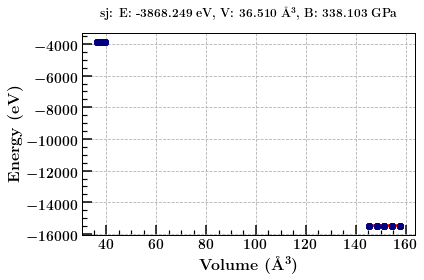

In [18]:
db = connect('bulk.db')
for m in metals:
    for f in functionals:
        metal = read("../../Resources/cif/tmc/"+m+"_conventional_standard.cif")
        fh = m + "_" + f
        MyEOSFitting(metal,db,fh,m, f)

Alpha-Mo2C_mp-1552_optB88-vdw.traj
326.79399072850106 GPa
Alpha-Mo2C_mp-1552_optB86B-vdw.traj
337.29871050420985 GPa
Alpha-Mo2C_mp-1552_optPBE-vdw.traj
321.7307535860887 GPa
Alpha-Mo2C_mp-1552_rVV10.traj
312.92641757972405 GPa
Alpha-Mo2C_mp-1552_PBE+D3.traj
341.6745982755227 GPa
Beta-Mo2C_mp-1221498_optB88-vdw.traj
322.1401356409985 GPa
Beta-Mo2C_mp-1221498_optB86B-vdw.traj
332.8931145969736 GPa
Beta-Mo2C_mp-1221498_optPBE-vdw.traj
317.22253004849273 GPa
Beta-Mo2C_mp-1221498_rVV10.traj
308.5213180562559 GPa
Beta-Mo2C_mp-1221498_PBE+D3.traj
338.1026104280924 GPa


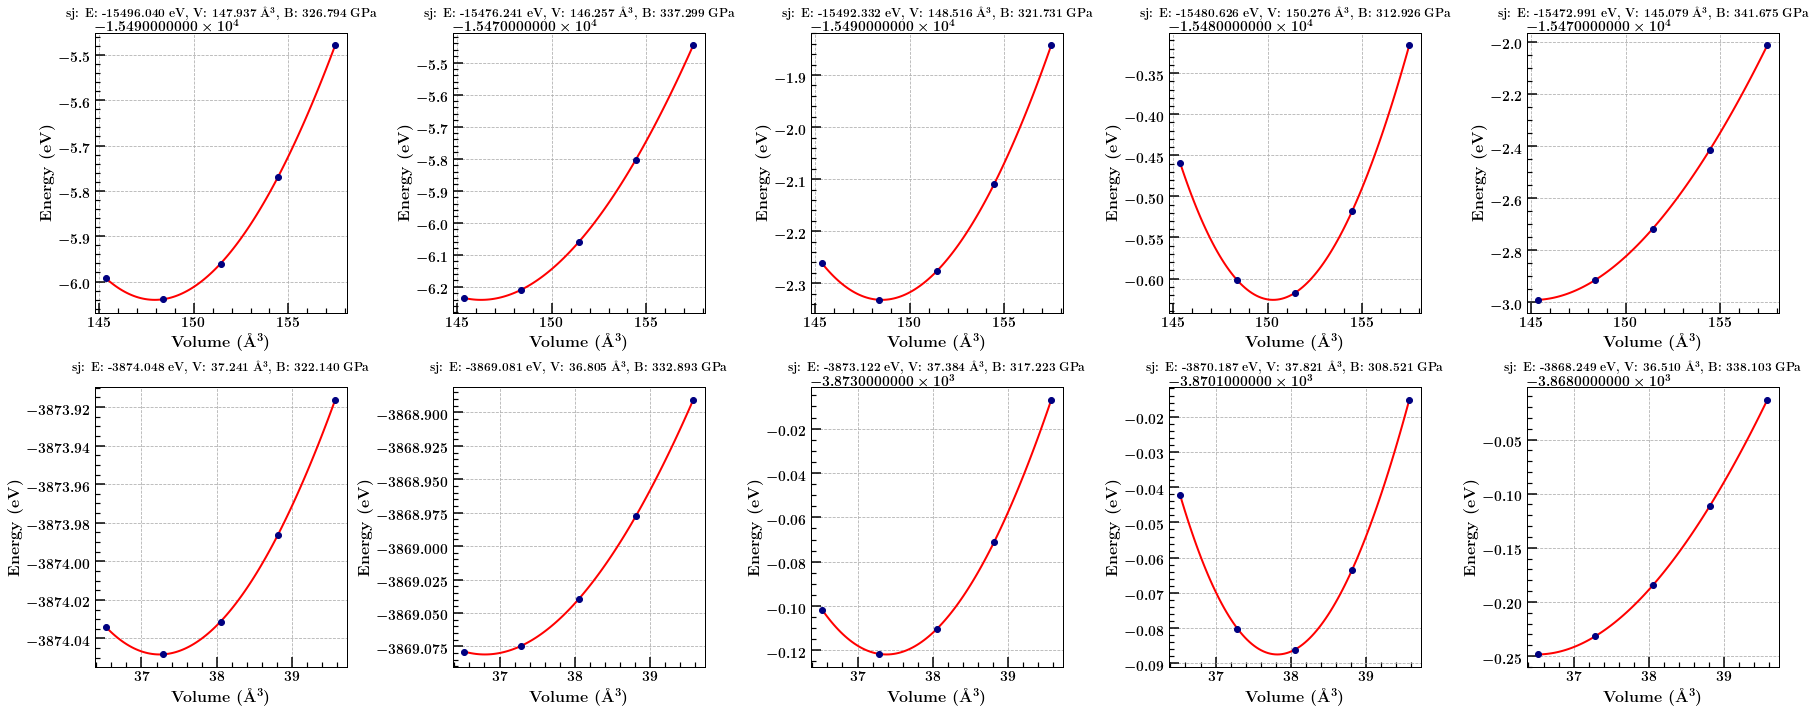

In [20]:
nr = len(metals)
nc = len(functionals)
fig, ax = plt.subplots(nrows=nr, ncols=nc, figsize=(5*nc,5*nr))

m_idx = 0
for m in metals:
    f_idx = 0
    for f in functionals:
        
        fh = m + "_" + f
        file = fh+".traj"
        configs = Trajectory(file)
        
        # Extract volumes and energies:
        volumes = [a.get_volume() for a in configs]
        energies = [a.get_potential_energy() for a in configs]
        eos = EquationOfState(volumes, energies)
        v0, e0, B = eos.fit()
        
        print(file)
        print(B / kJ * 1.0e24, 'GPa')
        eos.plot(ax=ax[m_idx][f_idx],show=False)
        
        f_idx += 1
    m_idx += 1
        
plt.tight_layout()
plt.savefig("eos.png")
plt.show()


## Surface Energies

In [ ]:

miller_indices = [(0,0,1), (1,0,1), (1,2,1), (1,2,0), (0,0,2)]

# We have the energy of the relaxed structure for each functional in the bulk db
db1 = connect('bulk.db')
db2 = connect('surface.db')

for idx in miller_indices:
    for m in metals:
        for f in functionals:
            
            midx_str = str(idx[0]) + str(idx[1]) + str(idx[2])
            
            fh = m + "_" + f +"_" + midx_str
            print(fh)
            
            id = db2.reserve(miller=midx_str, metal=m, xcfunctional=f)
            if id is not None:
                
                start = time.time()
                row = db1.get(xcfunctional=f, metal=m)
                uc = row.toatoms()
                uc_formula = uc.get_chemical_formula()
                
                # Get the Bulk Energy and Formula from the database
                e_bulk = uc.get_potential_energy()
                uc_symbols = uc.get_chemical_symbols()
                
                # Create the Surface
                unit_surface = surface(uc, indices=idx, layers=2, vacuum=5)
                unit_surface.set_pbc(True)
                unit_surface = sort(unit_surface, unit_surface.positions[:,2])
                
                c = FixAtoms(indices=[atom.index for atom in unit_surface if atom.position[2] < 0.5*np.sum(unit_surface.get_cell()[:,2])])
                unit_surface.set_constraint(c)
                
                unit_surface.calc = CP2KCalculator(
                    400, 
                    f,
                    kpoints=(4,4,1),
                    dipole_correction=False,
                    orbital_transform=False,
                    smearing=True
                )
                
                #Figure out how many unitcells make up this surface
                unit_surface_symbols = unit_surface.get_chemical_symbols()
                n_uc = len(unit_surface_symbols) // len(uc_symbols)
                
                #Get the Surface Area 
                surface_area = np.linalg.norm(np.cross(unit_surface.get_cell()[0], unit_surface.get_cell()[1]))
                
                #Do one SCF cycle to get the unrelaxed structure energy
                e_surface_unrelaxed = unit_surface.get_potential_energy()
                
                #Minimize the surface to get the relaxed structure
                minimizer = FIRE(unit_surface, trajectory=fh+"_fire.traj", logfile=fh+"_fire.log")
                minimizer.run(fmax=0.03)
                e_surface_relaxed = unit_surface.get_potential_energy()
                
                #calculate surface enrgy
                e_cleavage = 0.5*(e_surface_unrelaxed - n_uc*e_bulk)
                e_relaxation = e_surface_relaxed - e_surface_unrelaxed
                surface_energy = (e_cleavage + e_relaxation)/surface_area
                end = time.time()
                elapsed = end - start

                db2.write(unit_surface, id=id, miller=str(idx), metal=m, xcfunctional=f, totaltime=elapsed, ce=e_cleavage, re=e_relaxation, se=surface_energy)


Alpha-Mo2C_mp-1552_optB88-vdw_(0, 0, 1)
Alpha-Mo2C_mp-1552_optB86B-vdw_(0, 0, 1)
Alpha-Mo2C_mp-1552_optPBE-vdw_(0, 0, 1)


In [27]:
row = db1.get(xcfunctional="optB88-vdw", metal="Alpha-Mo2C_mp-1552")

In [34]:
miller_indices = [(0,0,1), (1,0,1), (1,2,1), (1,2,0), (0,0,2)]
for idx in miller_indices:
    print("1_"+str(idx))

1_(0, 0, 1)
1_(1, 0, 1)
1_(1, 2, 1)
1_(1, 2, 0)
1_(0, 0, 2)
